In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn import preprocessing as preproc # load preprocessing function
import warnings
warnings.filterwarnings("ignore")
sns.set()
from sklearn import tree
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor
from sklearn import linear_model


# Todo

## Time series
1. Gennemsnittet for de sidste N observationer per destination
2. Gennemsnittet for de sidste N søndage (og lørdage, mandage etc) eller bare delt op på hverdag/weekend
3. Kombi af 1. og 2. 




## Categorical
1. Tidspunkt på dagen 
2. Weekend/hverdag i stedet for ugedage

## "Weighted least squares "
1. Optimer den procentvise andel af data der bliver brugt (MSE) 

## Include more 
- Seatcapacity 
- Airline type 
- etc.

## Model parametre i Random forrest/regression trees
- m: number of variables to consider in each split. Good idea to tune it. But we can also use floor(p/3) for regression. When we use a subset to choose from in each split, we obtain the bagging variance, which is nice and which gives us the uncorrelated trees
- When there is too many variables that are not important, it lowers the performance 

## BIC og AIC for decision tree
- oob

## Feature selection 




In [2]:
# read data
data = pd.read_excel("data/realised_schedule.xlsx")


In [3]:
data


,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,0.408451
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,0.189189
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,0.570423
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,0.333333
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,0.204301
...,...,...,...,...,...,...,...,...,...
39444,2022-02-28 18:45:00,VW,986,YYZ,319,J,CA,144,0.847222
39445,2022-02-28 19:25:00,LJ,667,YDQ,319,J,CA,156,0.871795
39446,2022-02-28 20:00:00,VW,3406,MYV,E90,J,US,98,0.857143
39447,2022-02-28 19:30:00,LJ,663,RUT,32N,J,US,186,0.682796


## Data

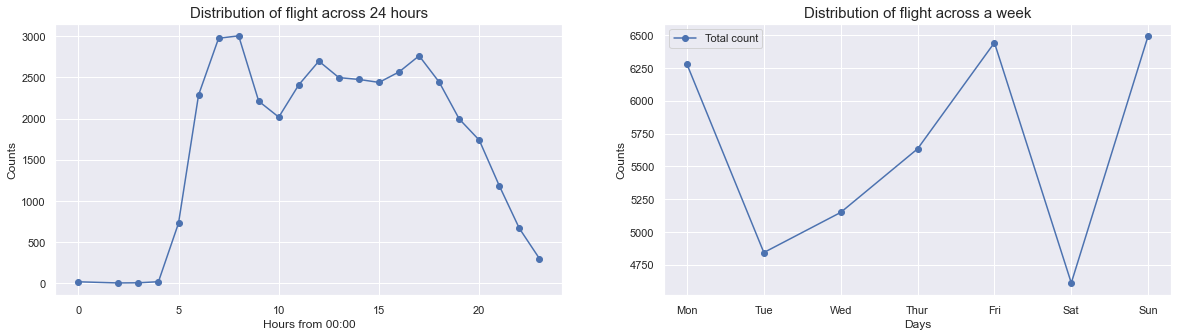

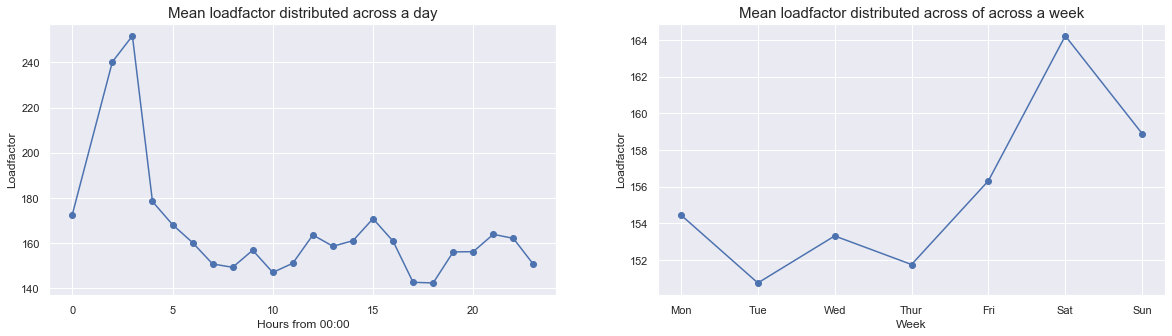

In [4]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
ax[0].plot(data.groupby(data["ScheduleTime"].dt.hour).count().LoadFactor, 'o-')
ax[0].set_title('Distribution of flight across 24 hours', fontsize = 15)
ax[0].set_xlabel('Hours from 00:00')
ax[0].set_ylabel('Counts')

ax[1].plot(data.groupby(data["ScheduleTime"].dt.weekday).count().LoadFactor, 'o-', label = 'Total count')
ax[1].set_title('Distribution of flight across a week', fontsize = 15)
ax[1].set_xlabel('Days')
ax[1].set_xticks(np.arange(0,7), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
ax[1].set_ylabel('Counts')
ax[1].legend()

################################

fig, ax = plt.subplots(1,2, figsize = (20,5))


ax[0].plot(data.groupby(data["ScheduleTime"].dt.hour).mean().SeatCapacity, 'o-')
ax[0].set_title('Mean loadfactor distributed across a day', fontsize = 15)
ax[0].set_xlabel('Hours from 00:00')
#ax[1].set_xticks(np.arange(0,7), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
ax[0].set_ylabel('Loadfactor')
#ax[0].legend()


ax[1].plot(data.groupby(data["ScheduleTime"].dt.weekday).mean().SeatCapacity, 'o-')
ax[1].set_title('Mean loadfactor distributed across of across a week', fontsize = 15)
ax[1].set_xlabel('Week')
ax[1].set_xticks(np.arange(0,7), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
ax[1].set_ylabel('Loadfactor')
#ax[1].legend()




plt.show()


## Analysing data

The plots above indicates that both day of week and time of day is important features to include

# Features

Categorical (for one-hot-encoding):
- Destination
- Airline
- Sector
- Flight type

Added categorical
- Weekday
- Hour of day

Continious
- Seat capacity 

Nessesary for additional features
- ScheduleTime
  
Time series (missing is replaced with mean value of some sort. For know it is the mean training oadfactor in general):
1. Destination
2. Sector
3. Airline 
4. Mean of last week 
5. Mean of last hour

y
- load factor

# Data
## Create variables

In [5]:
# choose rows of interrest
#data = df

## Modify features 

# Choose which features to use 
data = data[['Destination','Sector','FlightType','SeatCapacity','ScheduleTime','LoadFactor', 'Airline']] #''
data_ = data[[ 'Destination','Sector','FlightType','Airline' ]] # Airline

# Weekday features
data['weekday']=data['ScheduleTime'].dt.day_of_week 
 # string formatting nessesary for one-hot-encoding

# Hour feature
data['hour']= data['ScheduleTime'].dt.hour 
#data['hour'] = data.hour.apply(lambda x: str(x))


# Hours from first observation 
#time = (data.ScheduleTime - data.ScheduleTime.iloc[0]) /pd.Timedelta('1 hour') # substract time for first obs. and divide by hour
#min_ = time.min() 
#max_ = time.max()
#time =  (time - min_) / (max_ - min_) # min-max normalisation 
#data['time'] = time

# One hot encoding 


# Add variables which where expanded 
#data = pd.concat([data, data_], axis=1)

# add 5 variables with random noise for feature importance
for i in range(5):
    data[f'random_{i}'] = np.random.normal(size = data.shape[0])






### Loadfactor for the same destination/sector/airline, last time it was observed


In [6]:
# mean loadfactor for training data: will replace all missing values in the time series 
replacer_mu = data[data['ScheduleTime'] < '2022-02-01'].LoadFactor.mean() 


# create time series variables that holds the loadfactor of the last destination/sector/airline
new = ['time_prev_destination','time_prev_sector', 'time_prev_airline']
original = ['Destination', 'Sector', 'Airline']

for i, j in zip(new,original):  

# time_prev_destination
    data[i] = data.groupby(j)['LoadFactor'].shift()


data = data.fillna(replacer_mu)

data['week'] =  data['ScheduleTime'].dt.week
new_df_day = data.groupby(['week', 'weekday']).mean().reset_index()
new_df_hour = data.groupby(['week', 'hour']).mean().reset_index()

### Mean of loadfactor for the same day/hour last week

In [7]:

# Create time series variables: mean of 
prev_hour = []
prev_day = []
for i in range(len(data)):
    w = data.iloc[i]['week']
    d = data.iloc[i]['weekday']  
    h =  data.iloc[i]['hour']  
    if w == 1:
        prev_day.append(replacer_mu)
        prev_hour.append(replacer_mu)
    elif w != 1:
        d1 = new_df_day[new_df_day['weekday'] == d][new_df_day['week'] == w-1].LoadFactor
        h1 = new_df_hour[new_df_hour['hour'] == d][new_df_hour['hour'] == w-1].LoadFactor
        prev_day.append(d1.values[0])

        if len(h1) == 0:
            prev_hour.append(replacer_mu)

        else:

            prev_hour.append(h1.values[0])

    


In [8]:
data['prev_weekday'] = prev_day
data['prev_hour'] = prev_hour
data = data.fillna(replacer_mu)


data =  data.drop(['week'], axis = 1)
data['weekday'] = data.weekday.apply(lambda x: str(x))
data['hour'] = data.hour.apply(lambda x: str(x))



data = pd.get_dummies(data)

## Split in validation and training

In [9]:
# split into val and training data
val_data = data[data['ScheduleTime'] >='2022-02-01']
train_data = data[data['ScheduleTime'] < '2022-02-01']

In [10]:
# access relevant variables. That is, drop variables that are already one-hot-encoded 
# (but saved because we need them in order to get time series variables)

y_val = val_data.LoadFactor.values
y_train = train_data.LoadFactor.values

# 
X_train = train_data.drop(["LoadFactor", 'ScheduleTime'], axis = 1)
X_val = val_data.drop(["LoadFactor", 'ScheduleTime'], axis = 1)

# save columns for later
train_cols = X_train.columns
val_cols = X_val.columns
#X_train = train_data_ # 
#X_val = val_data_ #


# Models


## Random forrest

In [17]:
data.to_csv('updated_train_val_data.csv')

Model absolute error: 0.14401805846305435
Baseline error: 0.2824613007967415


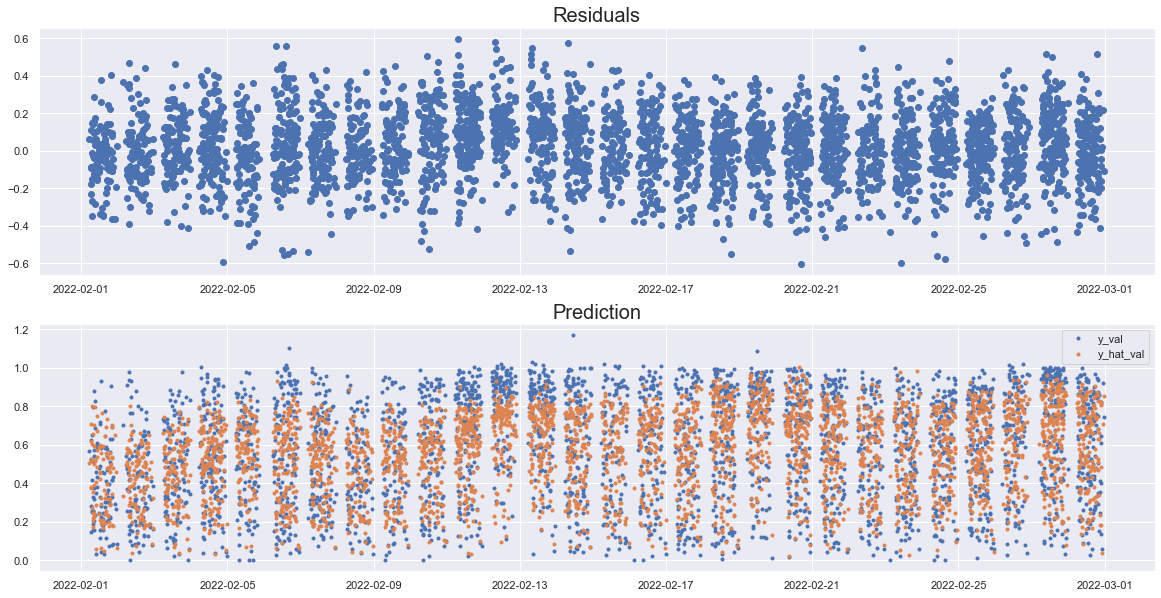

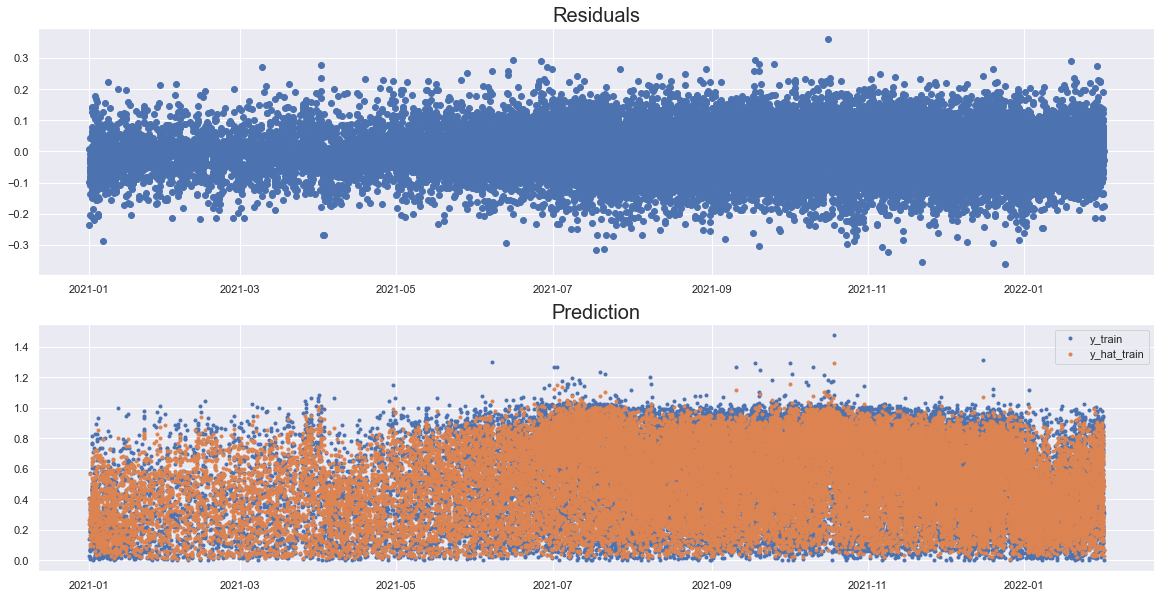

In [11]:
#model = AdaBoostRegressor(tree.DecisionTreeRegressor(min_samples_leaf = 1))#, ccp_alpha = n)
model = ensemble.RandomForestRegressor(n_estimators= 50 )
model.fit(X_train,y_train, sample_weight =  0.99998889 *X_train.index.values[::-1]) 
yhat = model.predict(X_val)
yhat_train = model.predict(X_train)


model_err = np.mean(abs(y_val - yhat))
print(f'Model absolute error: {model_err}')

baseline_err = abs(y_val - train_data[train_data['ScheduleTime']>'2022-01-01'].LoadFactor.mean()).mean()
print(f'Baseline error: {baseline_err}')

fig, ax = plt.subplots(2,1, figsize = (20,10))
plt.title('Validation data')
ax[0].scatter(val_data.ScheduleTime, y_val - yhat)
ax[0].set_title('Residuals',fontsize = 20)

ax[1].plot(val_data.ScheduleTime, y_val,'.', label = 'y_val')
ax[1].plot(val_data.ScheduleTime, yhat,  '.', label = 'y_hat_val',)
ax[1].set_title('Prediction',fontsize = 20 )
ax[1].legend()


fig, ax = plt.subplots(2,1, figsize = (20,10))
plt.title('Training data')
ax[0].scatter(train_data.ScheduleTime, y_train - yhat_train)
ax[0].set_title('Residuals',fontsize = 20)

ax[1].plot(train_data.ScheduleTime, y_train,'.', label = 'y_train')
ax[1].plot(train_data.ScheduleTime, yhat_train,  '.', label = 'y_hat_train')
ax[1].set_title('Prediction',fontsize = 20 )
ax[1].legend()

plt.show()

# Feature importance

In [12]:
# define split criterion importance
importance = model.feature_importances_

# sort index low --> high
sorted_idx = np.argsort(importance)

# find indices of random noise
random_idx = [np.where(train_cols == f'random_{i}')[0][0] for i in range(5)]

# find mean improvement for random noise
random_mean = importance[random_idx].mean()
important = np.argwhere(importance > random_mean)

# features that are more important than random noise 
for var, i in zip(train_cols[important], importance[important]):
    print(var,i )
 


['random_0'] [0.02837612]
['random_3'] [0.02913996]
['time_prev_destination'] [0.36385789]
['time_prev_sector'] [0.03165864]
['time_prev_airline'] [0.13295776]
['prev_weekday'] [0.04569456]
['Airline_DO'] [0.10824177]


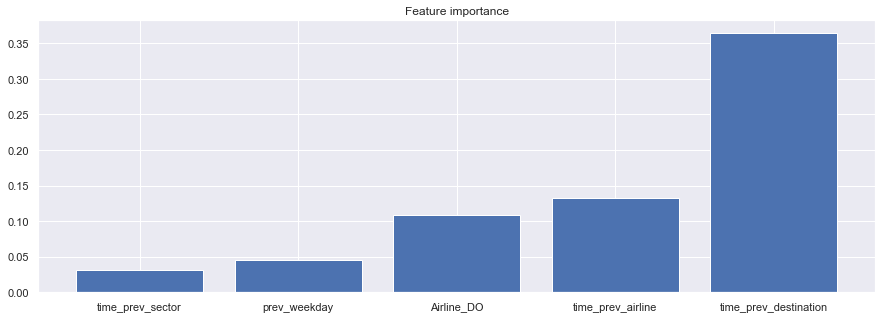

In [13]:
# plot most imporant variables
di = {var[0]: i[0] for var, i in zip(train_cols[important], importance[important])if 'random' not in var[0]}
di = {k: v for k, v in sorted(di.items(), key=lambda item: item[1])}

fig, ax = plt.subplots(1,1, figsize = (15,5))
ax.bar(np.arange(len(di)), height = di.values())
ax.set_xticks(np.arange(len(di)))
ax.set_xticklabels(di.keys())
ax.set_title('Feature importance')
plt.show()

# Model with important variables

In [14]:
X_train_new = X_train[di.keys()]
X_val_new = X_val[di.keys()]

# random forrest
forest = ensemble.RandomForestRegressor(n_estimators = 50)#, max_depth = 10#), max_features = 200)#, ccp_alpha = 0.1)
forest.fit(X_train_new,y_train, sample_weight=0.99998889 *X_train.index.values[::-1])
yhat = forest.predict(X_val_new)


model_err = np.mean(abs(y_val - yhat))
print(f'Forest absolute error: {model_err}')

Forest absolute error: 0.15630314847415594


# Gridsearch

## With all features 

In [15]:



# random forrest
parameters = {'n_estimators':np.arange(1, 100, step = 10), 'max_depth':np.arange(10, 100, step = 10), 'min_samples_leaf': np.arange(1, 50, step = 10), 'max_features':  np.arange(50, 350, step = 50)}
forest = ensemble.RandomForestRegressor()




lambdas = np.linspace(0.9999,1,N)
n_estimators = np.arange(1, 100, step = 10)
max_depth = np.arange(10, 100, step = 10)
min_samples_leaf =  np.arange(1, 50, step = 10)
max_features = np.arange(50, 350, step = 50)
errors = []
for l in lambdas:
    for n_est in n_estimators:
        for d in max_depth:
            for leaf in min_samples_leaf:
                for f in max_features:

                    tree = DecisionTreeRegressor()
                    tree.fit(X_train, y_train, sample_weight = lambdas[i]**X_train.index.values[::-1])
                    y_hat = tree.predict(X_val)
                    errors.append(abs(y_val - y_hat).mean())

    
#, max_depth = 10, max_features = 200)#, ccp_alpha = 0.1)
#forest.fit(X_train,y_train, sample_weight = (8*10**6))
#yhat = forest.predict(X_val)


#model_err = np.mean(abs(y_val - yhat))
#print(f'Forest absolute error: {model_err}')


NameError: name 'N' is not defined